This Public Health Dataset represents people's medical records.

**age:** age in years <br>
**sex:** (1 = male; 0 = female) <br>
**cp:** chest pain type <br>
**trestbps:** resting blood pressure (in mm Hg on admission to the hospital) <br>
**chol:** serum cholestoral in mg/dl<br>
**fbs:** (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)<br>
**restecg:** resting electrocardiographic results <br>
**thalach**: maximum heart rate achieved <br>
**exang:** exercise induced angina (1 = yes; 0 = no) <br> 
**oldpeak:** ST depression induced by exercise relative to rest <br>
**slope:** the slope of the peak exercise ST segment <br>
**ca:** number of major vessels (0-3) colored by flourosopy <br>
**thal:** 3 = normal; 6 = fixed defect; 7 = reversable defect <br>
**target**: 1 or 0. It refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease. <br>
*The main aim is to build a model that predicts a heart disease of a patient (target column) based on independent variables.*

In [ ]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer

def get_data(link: str) -> pd.DataFrame:

    logging.info('Extracting df')
    df = pd.read_csv(link)
    logging.info('Df is extracted')

    return df

df = get_data('/content/heart.csv')

#df.info()
#No null values
df.describe()
#sns.pairplot(df)
#g = sns.pairplot(df, hue="target", palette="husl")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
def data_split(data, target_var: str, test_size, the_random_state)->pd.DataFrame:
    
    logging.info('Filter out target column')
    X = df.drop(target_var, axis=1)
    y = df[target_var]
    logging.info('Splitting data')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = the_random_state)
    logging.info('Data is splitted')
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = data_split(df, "target", 0.3, 3)


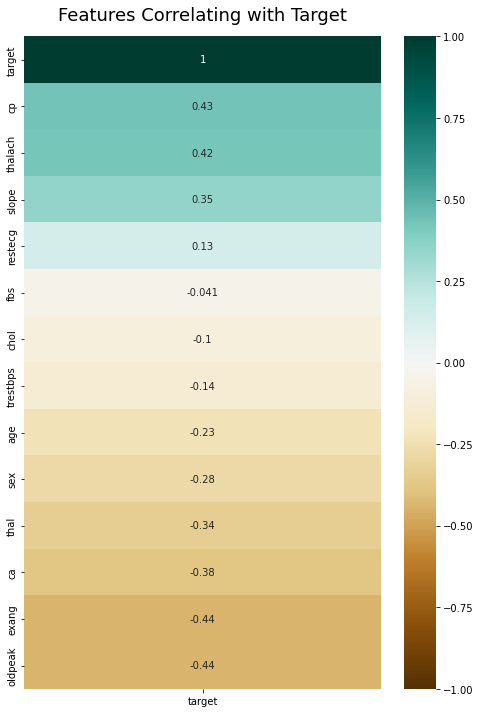

In [ ]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);

Text(0.5, 1.0, 'Correlation Heatmap')

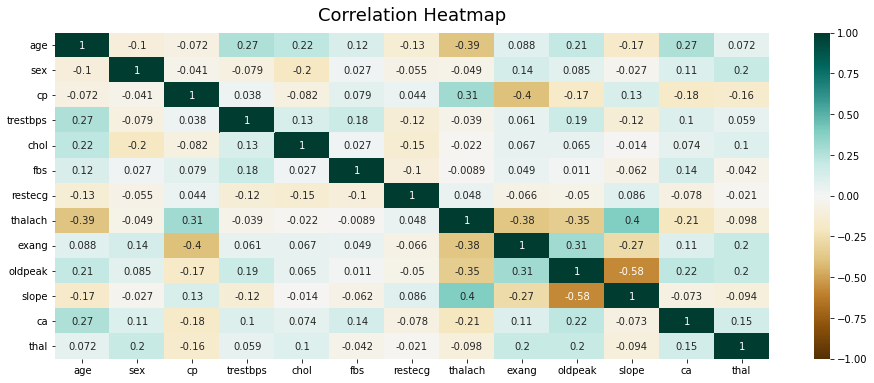

In [ ]:
#sns.heatmap(X.corr(), annot=True, fmt=".2f", linewidths=.3, cmap="crest")
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

There is no highly correlated features.

In [ ]:
def data_scaler(data):
  scaler = MinMaxScaler()
  data_scaled = scaler.fit_transform(data)
  data_scaled = pd.DataFrame(data_scaled,
                                 columns=data.columns)
  return data_scaled

X_train_scaled = data_scaler(X_train)
X_test_scaled = data_scaler(X_test)

In [ ]:
def NB_check(models_array, X_train_scaled, y_train, X_test_scaled, y_test):
  
    for this_model in models_array:

        logging.info('Initializing model')
        clf = this_model()
        logging.info('Training model')
        fitted_model = clf.fit(X_train_scaled, y_train)
        logging.info('Model is trained')
        logging.info('Calculating accuracy')
        print(f'Accuracy of your {this_model} model on training set: {fitted_model.score(X_train_scaled, y_train):.2f}')
        print(f'Accuracy of your {this_model} model on test set: {fitted_model.score(X_test_scaled, y_test):.2f}')
        logging.info('Accuracy is calculated')

NB_check([GaussianNB, MultinomialNB, ComplementNB, BernoulliNB], X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy of your <class 'sklearn.naive_bayes.GaussianNB'> model on training set: 0.85
Accuracy of your <class 'sklearn.naive_bayes.GaussianNB'> model on test set: 0.83
Accuracy of your <class 'sklearn.naive_bayes.MultinomialNB'> model on training set: 0.79
Accuracy of your <class 'sklearn.naive_bayes.MultinomialNB'> model on test set: 0.79
Accuracy of your <class 'sklearn.naive_bayes.ComplementNB'> model on training set: 0.79
Accuracy of your <class 'sklearn.naive_bayes.ComplementNB'> model on test set: 0.79
Accuracy of your <class 'sklearn.naive_bayes.BernoulliNB'> model on training set: 0.82
Accuracy of your <class 'sklearn.naive_bayes.BernoulliNB'> model on test set: 0.81


The Gaussian Naive Bayes model is overtrained because accuracy of the test set is lower than the train one. However, it shows the best accuracy, i will use it later.

In [ ]:
def nb_model_fit(model, X_train_scaled, y_train, **kwargs):
    logging.info('Model initialization')
    clf=model()
    logging.info('Fitting the model')
    fitted_model = clf.fit(X_train_scaled, y_train)
    logging.info('Model is fitted')
    return fitted_model

NB1=nb_model_fit(GaussianNB, X_train_scaled, y_train)

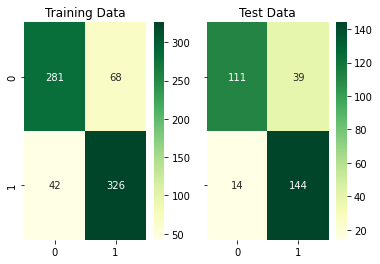

In [ ]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)
predict_train = NB1.fit(X_train_scaled, y_train).predict(X_train_scaled)
predict_test = NB1.predict(X_test_scaled)
#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [ ]:
print(classification_report(y_train, predict_train))
print(classification_report(y_test, predict_test))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       349
           1       0.83      0.89      0.86       368

    accuracy                           0.85       717
   macro avg       0.85      0.85      0.85       717
weighted avg       0.85      0.85      0.85       717

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       150
           1       0.79      0.91      0.84       158

    accuracy                           0.83       308
   macro avg       0.84      0.83      0.83       308
weighted avg       0.84      0.83      0.83       308



In [ ]:
#Hyperparameter Tuning to improve Accuracy
np.logspace(0,-9, num=10)

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

params_NB1 = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB1 = GridSearchCV(estimator=NB1, 
                     param_grid=params_NB1, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_test_scaled)

gs_NB1.fit(Data_transformed, y_test)

gs_NB1.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


{'var_smoothing': 0.43287612810830584}

In [ ]:
gs_NB1.best_score_

0.8244138903578353

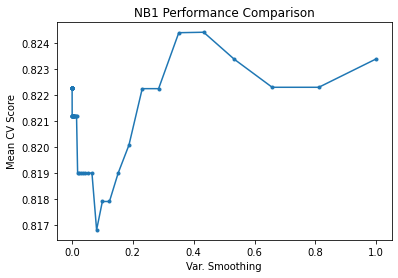

In [ ]:
results_NB1 = pd.DataFrame(gs_NB1.cv_results_['params'])
results_NB1['test_score'] = gs_NB1.cv_results_['mean_test_score']
plt.plot(results_NB1['var_smoothing'], results_NB1['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB1 Performance Comparison")
plt.show()

In [ ]:
def mean_validation_scores(model, X_train, y_train, cv):
  scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='accuracy')
  print('Cross-validation scores:{}'.format(scores.mean()))

mean_validation_scores(NB1, X_train_scaled, y_train, 10)

Cross-validation scores:0.846537558685446


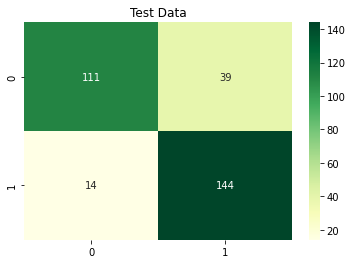

In [ ]:
NB2=nb_model_fit(GaussianNB, X_train_scaled, y_train, var_smoothing=0.43287612810830584)
#here save the model

The model is independent of the particular folds used for training.

In [ ]:
''''Checking scores with different kernels'''
def check_kernels(model, X_train_scaled, y_train, X_test_scaled, y_test, array_of_kernels):
    for this_kernel in array_of_kernels:
        logging.info('initializing the model with kernel')
        clf = model(kernel = this_kernel)
    
        logging.info('Training model with kernel')
        clf.fit(X_train, y_train)
    
        logging.info('Calculating accuracy')
        print(f'Accuracy of {this_kernel}-kernel SVC classifier on training set: {clf.score(X_train, y_train):.2f}')
        print(f'Accuracy of {this_kernel}-kernel SVC classifier on test set: {clf.score(X_test, y_test):.2f}')
        logging.info('Accuracies are calculated')

''''SVM scores with dif kernel parameters'''
check_kernels(SVC, X_train_scaled, y_train, X_test_scaled, y_test, ['poly', 'linear', 'sigmoid', 'rbf'])

Accuracy of poly-kernel SVC classifier on training set: 0.71
Accuracy of poly-kernel SVC classifier on test set: 0.70
Accuracy of linear-kernel SVC classifier on training set: 0.86
Accuracy of linear-kernel SVC classifier on test set: 0.81
Accuracy of sigmoid-kernel SVC classifier on training set: 0.55
Accuracy of sigmoid-kernel SVC classifier on test set: 0.54
Accuracy of rbf-kernel SVC classifier on training set: 0.69
Accuracy of rbf-kernel SVC classifier on test set: 0.69


In [ ]:
''''SVM model initialization'''

def check_gamma_c(model, X_train_scaled, y_train, X_test_scaled, y_test,  array_of_c, array_of_gamma, kernel_type:str):

      for this_gamma in array_of_gamma:

        for this_C in array_of_c:
          logging.info('initializing the model')
          clf = model(kernel = kernel_type, gamma=this_gamma, C = this_C)
          logging.info('Training model with kernel')
          clf.fit(X_train, y_train)
          logging.info('Calculating accuracy')
          print(f'SVM with kernel = {kernel_type}, gamma = {this_gamma} & C = {this_C}')
          print(f'Accuracy of this SVM classifier on training set: {clf.score(X_train, y_train):.2f}')
          print(f'Accuracy of this SVM  classifier on test set: {clf.score(X_test, y_test):.2f}\n')
          logging.info('Accuracies are calculated')

''''SVM scores with dif, gamma, C and kernel parameters'''
check_gamma_c(SVC, X_train_scaled, y_train, X_test_scaled, y_test,  [0.001, 0.01, 0.1, 1, 10, 100], [0.1, 1, 15], 'linear')
#best score was presented with linear kernel
#clf1 = SVC(kernel = 'linear')
#SVC2 = clf1.fit(X_train, y_train)
#pickle.dump(SVC2, open('model/conf/svm_linear_kernel.pkl', 'wb'))


SVM with kernel = linear, gamma = 0.1 & C = 0.001
Accuracy of this SVM classifier on training set: 0.77
Accuracy of this SVM  classifier on test set: 0.72

SVM with kernel = linear, gamma = 0.1 & C = 0.01
Accuracy of this SVM classifier on training set: 0.85
Accuracy of this SVM  classifier on test set: 0.81

SVM with kernel = linear, gamma = 0.1 & C = 0.1
Accuracy of this SVM classifier on training set: 0.86
Accuracy of this SVM  classifier on test set: 0.80

SVM with kernel = linear, gamma = 0.1 & C = 1
Accuracy of this SVM classifier on training set: 0.86
Accuracy of this SVM  classifier on test set: 0.81

SVM with kernel = linear, gamma = 0.1 & C = 10
Accuracy of this SVM classifier on training set: 0.85
Accuracy of this SVM  classifier on test set: 0.80

SVM with kernel = linear, gamma = 0.1 & C = 100
Accuracy of this SVM classifier on training set: 0.86
Accuracy of this SVM  classifier on test set: 0.83

SVM with kernel = linear, gamma = 1 & C = 0.001
Accuracy of this SVM classif

The best performance was from:
SVM with kernel = linear, gamma = 1 & C = 100
Accuracy of this SVM classifier on training set: 0.86
Accuracy of this SVM  classifier on test set: 0.83

In [ ]:
#save the model

In [ ]:
def c_check(model, X_train_scaled, y_train, X_test_scaled, y_test, array_of_c, kernel_type:str):
    
    for this_C in array_of_c:
      
            logging.info('Initializing model with C')
            clf = model(kernel = kernel_type, C = this_C)
            logging.info('Training model with C')
            clf.fit(X_train, y_train)
            logging.info('Model is trained with C')
            logging.info('Calculating accuracy')
            print(f'SVM with C = {this_C}')
            print(f'Accuracy of SVM {kernel_type} classifier on training set: {clf.score(X_train, y_train):.2f}')
            print(f'Accuracy of SVM {kernel_type} classifier on test set: {clf.score(X_test, y_test):.2f}\n')
            logging.info('Accuracy is calculated')


c_check(SVC, X_train_scaled, y_train, X_test_scaled, y_test, [0.001, 0.01, 0.1, 1, 10, 100], 'linear')

SVM with C = 0.001
Accuracy of SVM linear classifier on training set: 0.77
Accuracy of SVM linear classifier on test set: 0.72

SVM with C = 0.01
Accuracy of SVM linear classifier on training set: 0.85
Accuracy of SVM linear classifier on test set: 0.81

SVM with C = 0.1
Accuracy of SVM linear classifier on training set: 0.86
Accuracy of SVM linear classifier on test set: 0.80

SVM with C = 1
Accuracy of SVM linear classifier on training set: 0.86
Accuracy of SVM linear classifier on test set: 0.81

SVM with C = 10
Accuracy of SVM linear classifier on training set: 0.85
Accuracy of SVM linear classifier on test set: 0.80

SVM with C = 100
Accuracy of SVM linear classifier on training set: 0.86
Accuracy of SVM linear classifier on test set: 0.83



In [ ]:
clf = SVC()
SVC1 = clf.fit(X_train_scaled, y_train)
param_grid = {'C': [0.01, 0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid', 'lenear']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
